# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

# Tabla de contenido


1. [Introducción](#Introducción)

    1.1 [Objetivo general](#Objetivo-general)
    
    1.2 [Objetivos particulares](#Objetivos-particulares)
    
    
2. [Descripción de los datos](#Descripción-de-los-datos)


3. [Preparación](#Preparación)


4. [Análisis](#Análisis)


5. [Formación](#Formación)

    5.1 [Generación de características para modelo de entrenamiento](#Generación-de-características-para-modelo-de-entrenamiento)


6. [Prueba](#Prueba)

    6.1 [Modelo de regresión lineal](#Modelo-de-regresión-lineal)
    
    6.2 [Modelo ARIMA](#Modelo-ARIMA)


7. [Conclusión](#Conclusión)

## Instrucciones

### Objetivo general

- Construir un modelo de predicción para atraer más taxis al aeropuerto durante las horas pico.

### Objetivos particulares

- Descarga los datos y haz el remuestreo por una hora.
- Analiza los datos.
- Entrena diferentes modelos con diferentes hiperparámetros y optar por el modelo con mejor desempeño. La muestra de prueba debe ser el 10% del conjunto de datos inicial.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

## para hacer modelos de aprendizaje GBDT
import lightgbm as lgb

## modelo de linea de regresion
from sklearn.linear_model import LinearRegression

## para la división y subconjunto de datos (train y test)
from sklearn.model_selection import train_test_split

## para importar métricas de evaluación
from sklearn.metrics import mean_squared_error

## bibilioteca para determinar una serie temporal estacionaria
from statsmodels.tsa.stattools import adfuller

## modelo de aprendizaje para series temporales ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Descripción de los datos

- **num_orders** -- El número de pedidos de taxis en esa hora.

In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

In [6]:
df.reset_index().duplicated().sum()

0

En una observación preliminar se logra tomar nota de que no existen valores nulos ni duplicados por lo que estos datos ya vienen relativamente limpios, por otro lado se revisa su estadística encontrandonos con algunos valores atípicos (max de 119 cuando la std es de 9.2) pero sin valores incongruentes, como valores negativos, hay que recordar que los datos expuestos en `num_orders` responden a la cantidad de solicitudes de taxi, por o que no es de esperar valores negativos y es raro tener valores de 0, aunque sí pudiera haber excepeciones de esto último.

## Preparación

<AxesSubplot:xlabel='datetime'>

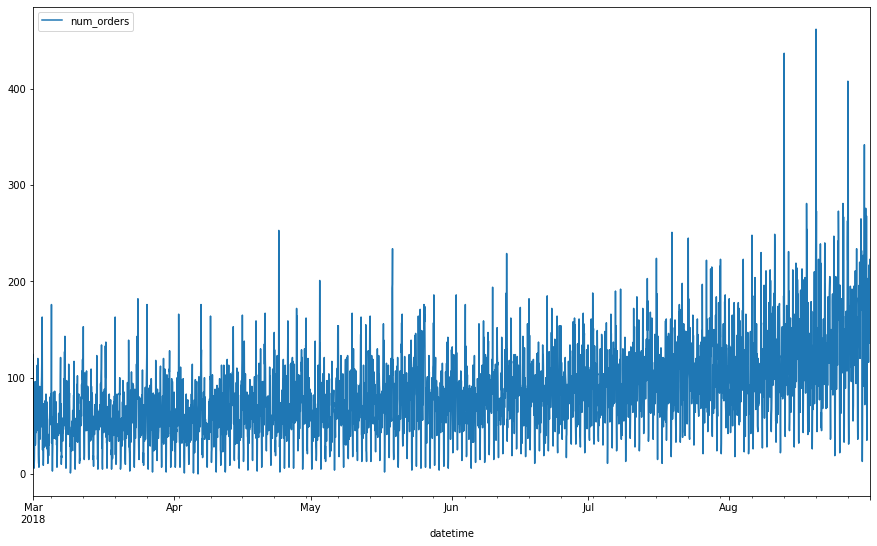

In [7]:
df = df.resample('1H').sum()
df.plot(figsize=(15,9))

In [8]:
df['rolling_mean'] = df.rolling(7).mean()

<AxesSubplot:xlabel='datetime'>

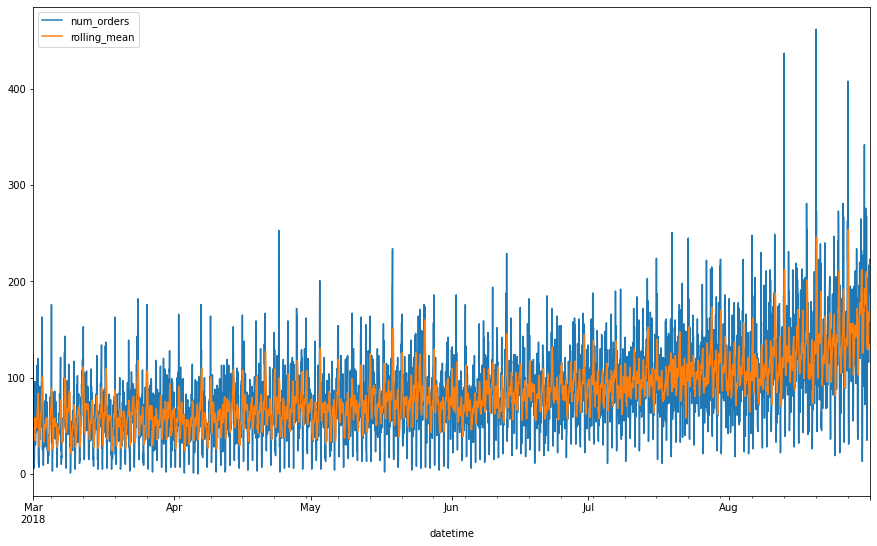

In [9]:
df.plot(figsize = (15,9))

Realizando una inspección gráfica preliminar con el concentrado de datso y agrupado por horas desde el inicio del mes de marzo hasta finales del mes de agosoto se logran observar en estos 6 meses una tendencia ascendente clara, siendo congruente a los meses de alta demanda o alta temporada de vaijes; se logra observar que existen días done existe un marcado indice de pedidos (>100), por lo que podemos hacer un filtro y hacer una observación de cuáles son esos días y en qué horas es que ocurren esos picos.

In [10]:
upper_df = df.dropna().query('num_orders > 100')

<AxesSubplot:ylabel='week'>

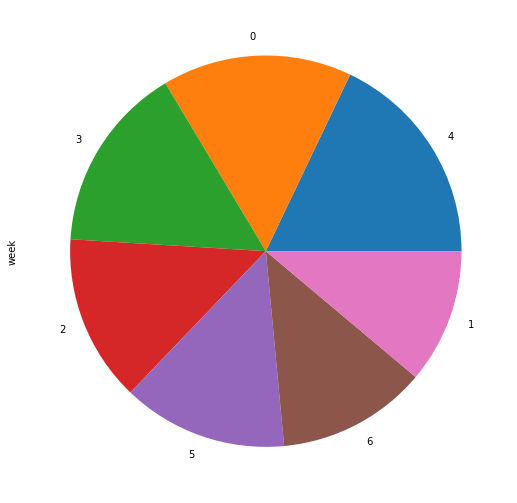

In [11]:
upper_df['week'] = upper_df.index.dayofweek
upper_df['week'].value_counts().plot(figsize = (15,9), kind='pie')

Se observa que no hay una diferencia significativa entre los días de la semana.

<AxesSubplot:>

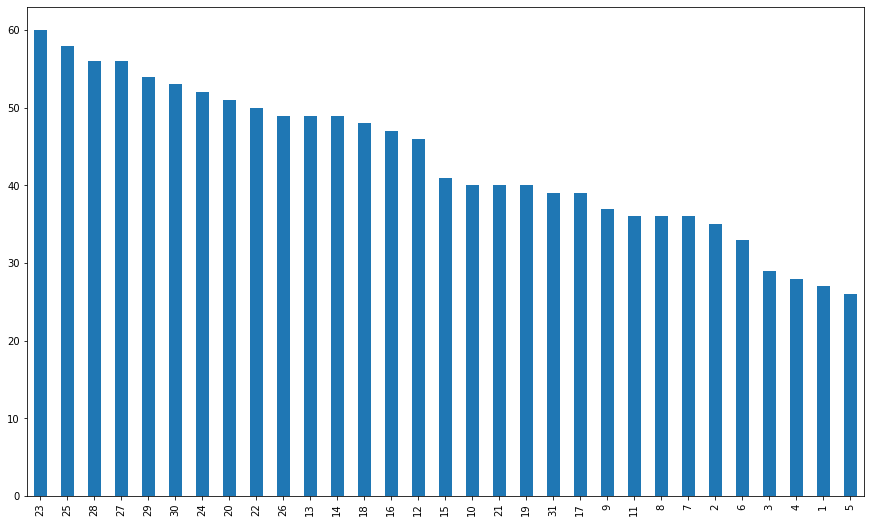

In [12]:
upper_df['day'] = upper_df.index.day
upper_df['day'].value_counts().plot(figsize = (15,9), kind='bar')

Aquí tiene algo más de significado, al ver que los días de la segunda quincena del mes tienen mayor frecuencia al tener horas con mayores pedidos, mientras que los días primeros del mes es menor la frecuecia de tener horas como mayores pedidos.

<AxesSubplot:>

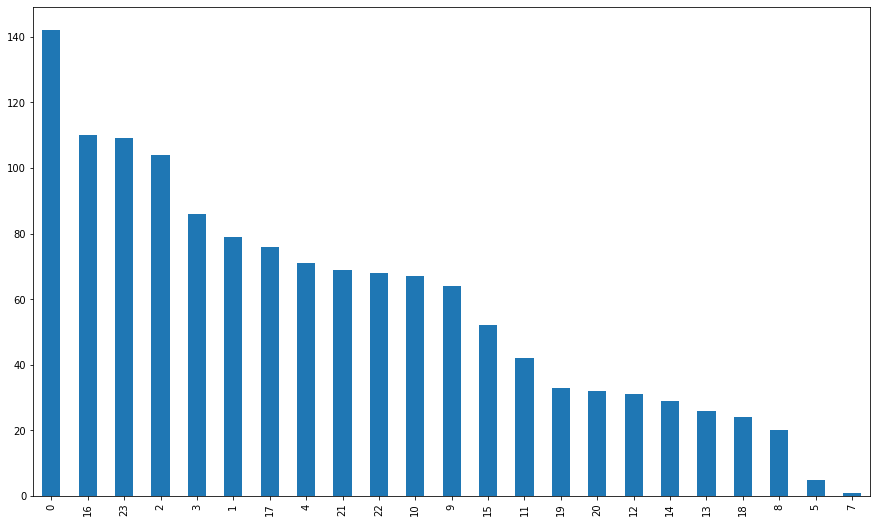

In [13]:
upper_df['hour'] = upper_df.index.hour
upper_df['hour'].value_counts().plot(figsize = (15,9), kind='bar')

Por último, al hacer una agrupación de las horas donde existe un mayor número de pedidos independientemente del día de la semana o del mes se logra ver una marcada tendencia de las horas pico de pedidos siendo en orden descendente las 00:00, 16:00  y 23:00 las horas pico, es decir, es en estas horas donde es más probable que se pidan taxis y también en orden descendente, 07:00, 5:00 y 8:00 las horas donde casi no hay una buena cantidad de pedidos, la conclusión intermedia es que por la mañana casi no se solicita el servicio de taxis en este aeropuerto.

## Análisis

Si se observara solo el gráfico anterior no podríamos obtener información reelevante, se sugiere hacer medida de la tendencia y periodicidad tomando como segmento temporal cualquier día de manera aleatoria y de ese modo observar de primera instancia si existen diferencias, minimos, máximos o una serie consolidada donde lso cambios casi no varían con el tiempo.

<AxesSubplot:xlabel='datetime'>

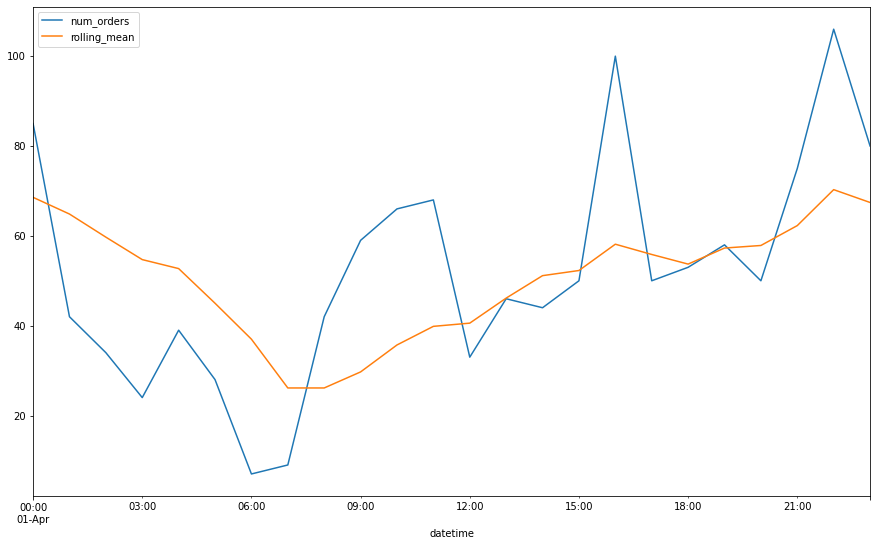

In [14]:
df['2018-04-01 00:00:00':'2018-04-01 23:59:59'].plot(figsize=(15,9))

Haciendo un análisis rápido de un día aleatorio se observa que existe un descenso en la solicitud de taxis mientras transcurre la mañana y un ascenso durante la tarde hasta llegada la medianoche; como sólo es un fragmento de toda la serie temporal disponible esto no arroja información determinante pero nos da una orientación de cómo se comporta por día.

Para corroborar lo anterior, se va a agrupar el número de solicitudes por hora de todos los días y estableceremos como parámetro estadístico la media.

<AxesSubplot:xlabel='hour'>

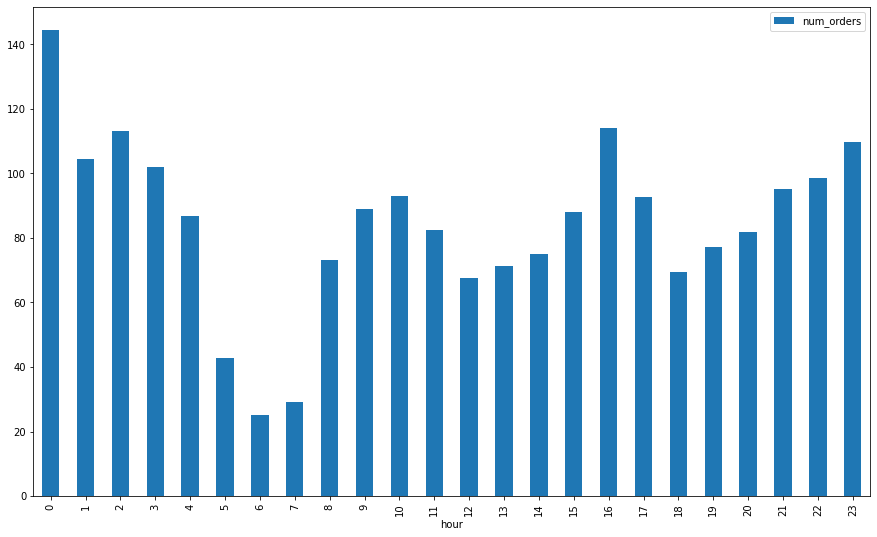

In [15]:
df['hour'] = df.index.hour
df.pivot_table(index = 'hour', values='num_orders', aggfunc='mean').plot(kind = 'bar', figsize=(15,9))

<!-- # eliminar valores ausentes
# df = df.dropna() -->

Con lo anterior se confirma nuevamente sobre las horas donde existe de manera marcada cuáles son las horas donde se hace una mayor cantidad de solicitudes.

Por otro lado, el análisis de tendencia y estacionalidad sobre toda la data de la serie temporal disponible se expresa a continuación:

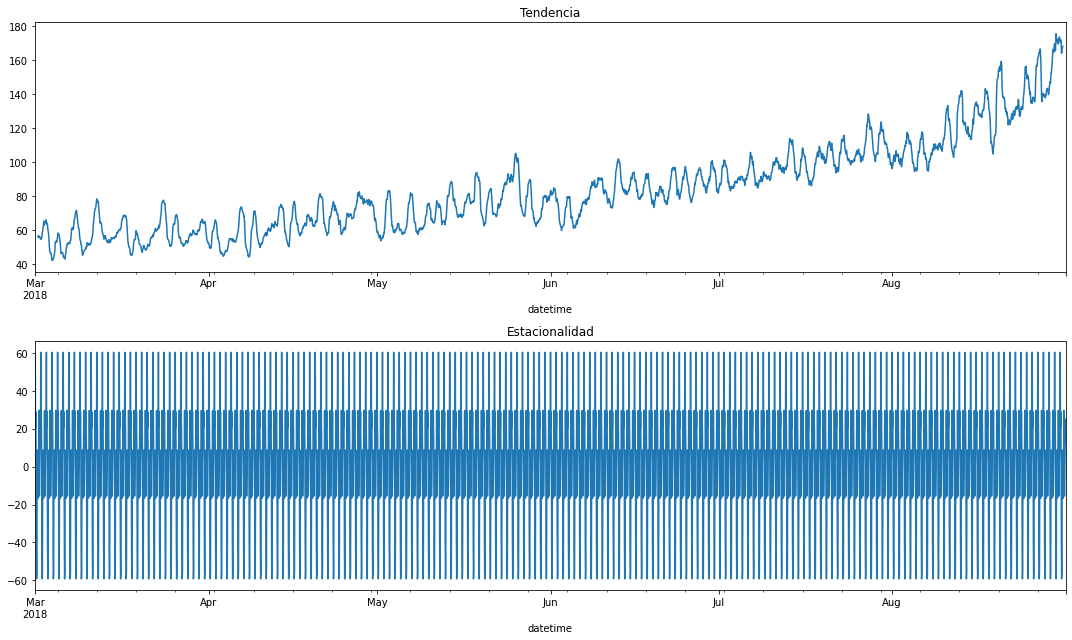

In [16]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15,9))

plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.tight_layout() 

Se observa que esta serie temporal **no es estacionaria** por lo que tendremos que hacer transformaciones adicionales si queremos hacer modelos de predicción con ella.
También se logra ver una marcada tendencia con respecto al mes del año, siendo una alta demanda de julio hata septiembre (que es hasta donde se tienen  datos) por lo que si se quiere hacer algún tipo de modelo de pronóstico es necesario corregir la tendencia.

## Formación

El primer objetivo a cumplir para hacer modelo de predicción con los datos es conseguir que la serie temporal tenga una forma estacionaria, como en nuestros datos originales no existe estacionaridad vamos a hacer una transformación de los datos mediante la diferencia de los valores con la media móvil con una ventana de 5 para empezar.

In [17]:
df = df[['num_orders','rolling_mean']]
df['stationality'] = df['num_orders'] - df['rolling_mean']
df = df.dropna()

<AxesSubplot:xlabel='datetime'>

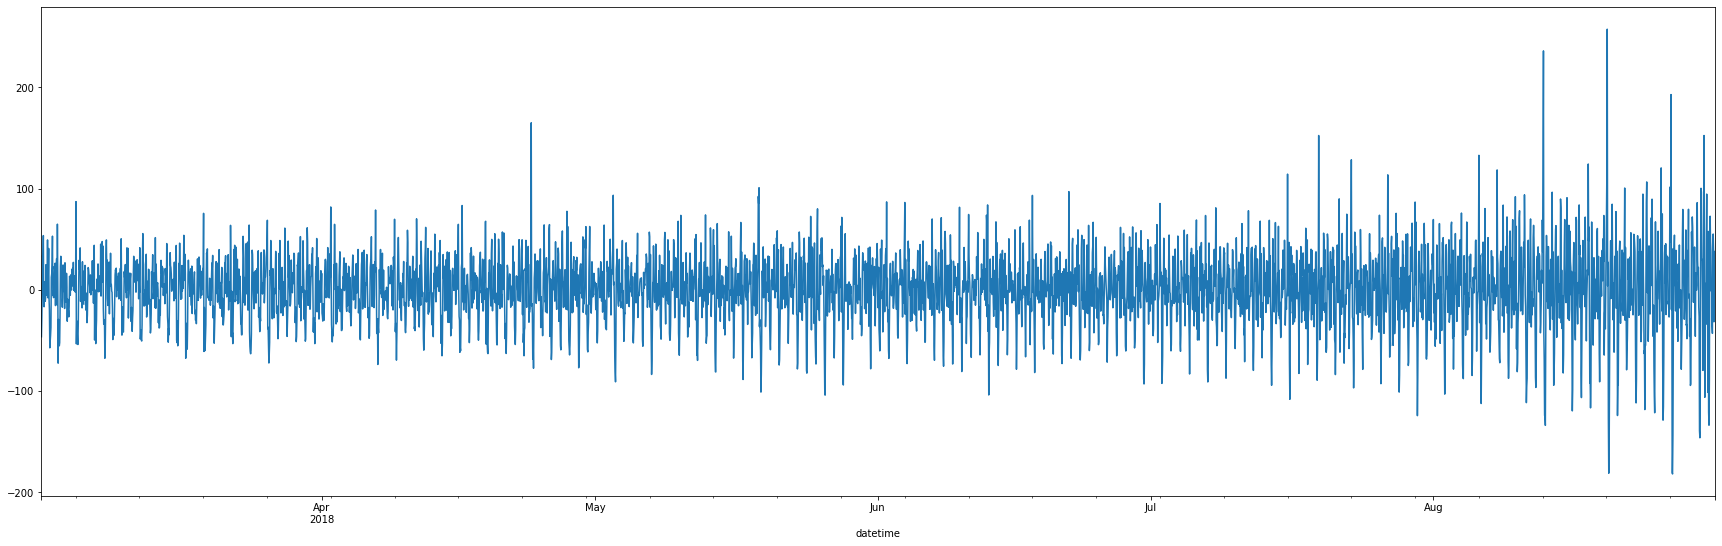

In [18]:
df['stationality'].plot(figsize=(30,9))

A pesar de que aparentemente se ha llegado a una consolidación, en necesario evaluarlo con algun método, en esta ocasión se va a utilizar decompose.

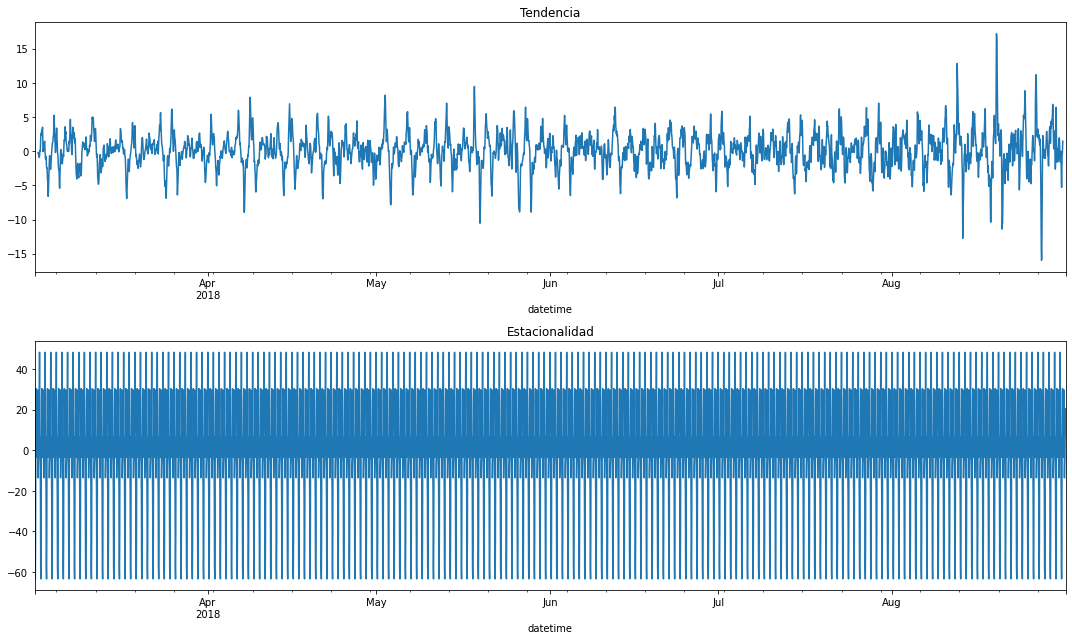

In [19]:
decomposed = seasonal_decompose(df['stationality'])

plt.figure(figsize=(15,9))

plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.tight_layout() 

Gráficamente se ve una consolidación en la serie temporal lo cual será muy bueno para generar los datos de entrenamiento y prueba, aún así, se necesita corroborar analíticamente que esta serie temporal objetivo realemnte sea unaserie estacionaria.

Se hará un diagnóstico con el test Dickey-Fuller para determinar la estacionaridad.

In [20]:
# realizar el test

is_stationarity = adfuller(df['stationality'].values)

# imprimir los resultados
print('Estadística de prueba:', is_stationarity[0])
print('Valor p:', is_stationarity[1])
print('Valores críticos:')
for clave, valor in is_stationarity[4].items():
    print(f'  {clave}: {valor}')

Estadística de prueba: -15.51666941353436
Valor p: 2.31156387752683e-28
Valores críticos:
  1%: -3.4318435256069204
  5%: -2.8621999562958633
  10%: -2.5671212990590764


No sólo de manera gráfica se logra distinguir la estacionaridad sino que mediante el test Dickey-Fuller se corrobora la inspección al tener una estadística de prueba con un valor menos que sus valores críticos y con una p < 0.001 se descarta la hipótesis nula que mencionaría que la serie temporal testeada no es estacionaria.

### Generación de características para modelo de entrenamiento

Al transformar la serie temporal a valores que expresan una serie estacionaria, se van a crear nuevas características para crear un set de datos de entrenamiento y prueba.

In [21]:
df = pd.DataFrame(df['stationality'])

In [22]:
# creación de características
# crear función
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['stationality'].shift(lag)

    data['rolling_mean'] = data['stationality'].shift().rolling(rolling_mean_size).mean()
    
# ejecutar la nueva función
make_features(df, 6, 5)

In [23]:
df.head()

,stationality,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 06:00:00,-46.142857,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,-27.571429,2018,3,1,3,-46.142857,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,-1.285714,2018,3,1,3,-27.571429,-46.142857,NaN,NaN,NaN,NaN,NaN
2018-03-01 09:00:00,34.000000,2018,3,1,3,-1.285714,-27.571429,-46.142857,NaN,NaN,NaN,NaN
2018-03-01 10:00:00,29.285714,2018,3,1,3,34.000000,-1.285714,-27.571429,-46.142857,NaN,NaN,NaN


Hasta este punto se ha logrado obtener la generación de nuevas características para enriquecer el entrenamiento de modelos. por último, sólo hace falta la bifurcación de datos en conjunto de entrenamiento y prueba, recordando que el split no debe de ser de orden aleatorio.

In [24]:
train, test = train_test_split(df, shuffle=False, test_size = 0.1, random_state= 17354)
train = train.dropna()

X_train = train.drop(['stationality'], axis = 1)
y_train = train['stationality']
X_test = test.drop(['stationality'], axis = 1)
y_test = test['stationality']

## Prueba

Se pretende hacer el entrenamiento en modelos de aprendizaje con diferentes tamices, el primero de ellos será a través de La regresión lineal.

### Modelo de regresión lineal

In [25]:
# # ejecutar entrenamiento
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
print('RECM para el conjunto de entrenamiento:', mean_squared_error(y_train_pred, y_train)**0.5)

RECM para el conjunto de entrenamiento: 27.489959887368233


Se evaluará ahora el modelo anterior utilizando la métrica de evaluación de error de la raíz cuadrada media (RECM) para evaluar la calidad del modelo.

In [26]:
y_test_pred = lr_model.predict(X_test)
print('RECM para el conjunto de prueba:', mean_squared_error(y_test_pred, y_test)**0.5)

RECM para el conjunto de prueba: 45.29170286426309


El objetivo de este proyecto es el tener al menos un RECM menor a 48 con lo cual se logra ver que se cumple, sin embargo, vamos a evaluar con otro modelo sólo para tener una comparación entre diferentes enfoques de aprendizaje automático.

### Modelo ARIMA

Se van a utilizar con varios parámetros de q, siendo d =1 ya que sólo se realizó un ajuste de diferencias, Se pretende buscar un RECM < 48.

In [27]:
stationality_df = df['stationality']

In [28]:
# Crear el modelo ARIMA y ajustarlo a los datos de entrenamiento
## pdq = 1,1,1
model_ari = ARIMA(stationality_df.values, order=(1, 1, 1))
model_fit = model_ari.fit()
y_predict = model_fit.predict()
y_predict_train, y_predict_test = train_test_split(y_predict, shuffle=False, random_state =129, test_size=0.1)
print('RECM para el conjunto de entrenamiento:', mean_squared_error(y_predict_test, y_test)**0.5)

RECM para el conjunto de entrenamiento: 48.52044656437664


In [29]:
## pdq = 1,1,2
model_ari = ARIMA(stationality_df.values, order=(1, 1, 2))
model_fit = model_ari.fit()
y_predict = model_fit.predict()
y_predict_train, y_predict_test = train_test_split(y_predict, shuffle=False, random_state =129, test_size=0.1)
print('RECM para el conjunto de entrenamiento:', mean_squared_error(y_predict_test, y_test)**0.5)

RECM para el conjunto de entrenamiento: 48.430054872789924


In [30]:
## pdq = 1,1,3
model_ari = ARIMA(stationality_df.values, order=(1, 1, 3))
model_fit = model_ari.fit()
y_predict = model_fit.predict()
y_predict_train, y_predict_test = train_test_split(y_predict, shuffle=False, random_state =129, test_size=0.1)
print('RECM para el conjunto de entrenamiento:', mean_squared_error(y_predict_test, y_test)**0.5)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RECM para el conjunto de entrenamiento: 47.71906262901611


Se logró crear un modelo de naturaleza ARIMA y parámetros p=1, d=1 y q=3 con un RECM < 48 cumpliendo con el requisito de la empresa.

## Conclusión


Se lograron obtener dos modelos de aprendizaje que hacen una predicción con RECM menos a 48 para lo cuál fue necesario la estacionariedad de la serie temporal utilizada ya que presentaba cierto nivel de tendencia ascendente en los dos meses finales; dentro de los dos modelos utilizados el que fue más cómodo de utilizar fue la regresión lineal y fue la más rápida, sin embargo, el modelo ARIMA puede dar mayor flexibilidad al arrojarnos más información y utilizar todo el conjunto de datos para hacer la predicción, dando un tiempo real de una predicción si así se quisiera.